In [2]:
#!pip3 install --user astropy

In [2]:
import numpy as np
import astropy as ap
import pandas as pd
from astropy.io import fits
import scipy.linalg as slg
from scipy.stats import norm
from math import ceil

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import glob
import os
# These are in Functions
from os.path import join as pj
# from os.path import abspath as absp

from IPython.display import Image
from IPython.display import display

from joblib import Parallel, delayed

import PIL
import pickle

import sys

In [3]:
os.environ["SPARCFIRE_HOME"] = "/home/portmanm/sparcfire_matt/"

_HOME_DIR = os.path.expanduser("~")
try:
    _SPARCFIRE_DIR = os.environ["SPARCFIRE_HOME"]
    _MODULE_DIR = pj(_SPARCFIRE_DIR, "GalfitModule")
except KeyError:
    if __name__ == "__main__":
        print("SPARCFIRE_HOME is not set. Please run 'setup.bash' inside SpArcFiRe directory if not done so already.")
        print("Checking the current directory for GalfitModule, otherwise quitting.")
            
        _MODULE_DIR = pj(os.getcwd(), "GalfitModule")
        
        if not exists(_MODULE_DIR):
            raise Exception("Could not find GalfitModule!")
    
sys.path.append(_MODULE_DIR)
from Classes.Components import *
from Classes.Containers import *
from Classes.FitsHandlers import *
from Functions.helper_functions import *

In [4]:
run_path = os.getcwd()
if in_notebook():
    run_path = run_path.replace("ics-home", "portmanm")

in_dir  = "sparcfire-in"
out_dir = "sparcfire-out"
tmp_dir = "sparcfire-tmp"
#galfits_tmp = "galfits"
#galfit_masks = "galfit_masks"
#galfit_out = "all_galfit_out"
nmr = "norm_masked_residual"

In [10]:
def check_galfit_chi(gal_name, base_path):
    # An example line
    # # Chi^2/nu = 4.661,  Chi^2 = 12025.575,  Ndof = 2580
    
    #galfit_txt_out = "galfit.01" # in the future galfit.01 may change
    filename = pj(base_path, gal_name, galfit_txt_out)
    with open(filename, "r") as f:
        for line in f:
            if "Chi" in line:
                chi_line = line.strip("# ")
    
    # This also works but it's quite devious...
    # chi_line.replace("^", "").replace("/", "_").replace(",  ", "\n").lower()
    # exec(chi_line)
    
    out_vals = chi_line.split(",")
    chi2_nu = float(out_vals[0].strip().split("=")[-1])
    chi2 = float(out_vals[1].strip().split("=")[-1])
    ndof = int(out_vals[2].strip().split("=")[-1])
    
    return chi2_nu, chi2, ndof

In [ ]:
basename   = "GALFIT"
pickle_filename = pj(out_dir, f'{basename}_output_nmr.pkl')
#all_gnames = find_files(out_dir, "123*", "d")
#total_gal  = len(all_gnames)

In [ ]:
# gzoo_file = pj(_HOME_DIR, "kelly_stuff", "Kelly-29k.tsv")
# gzoo_data = pd.read_csv(gzoo_file, sep = "\t", index_col = "GZ_dr8objid", dtype = {"GZ_dr8objid" : str})
# gzoo_data["spirality"] = gzoo_data.P_CW + gzoo_data.P_ACW
# selected_data = gzoo_data[gzoo_data.index.isin(all_gnames)]

## PLOT MAX ARM LENGTH VS SPIRALITY

In [ ]:
# max_arm_lengths = {}
# for gname in all_gnames:
#     csv_filename = pj(out_dir, gname, f"{gname}.csv")
#     with open(csv_filename, 'r') as f:
#         reader = csv.DictReader(f, skipinitialspace = True)
#         for row in reader:
#             max_arm_lengths[gname] = row.get('maxArcLength', None)
#             break

In [ ]:
# selected_data.loc[:, "maxArcLength"] = pd.Series(max_arm_lengths, dtype = np.float32)

In [ ]:
# px.scatter(selected_data, x = "maxArcLength", y = "spirality")

In [13]:
output_fits_norm_residuals = pickle.load(open(pickle_filename, 'rb'))

In [ ]:
residual_df = pd.DataFrame.from_dict(output_fits_norm_residuals, 
                                     orient = 'index', 
                                     columns = [nmr, "pvalue", "statistic"]
                                    )
# We no longer skip failed fits but fill with None
total_gal = len(residual_df)
residual_df.dropna(inplace = True)
residual_df["pvalue"] = 1 - residual_df["pvalue"]

In [ ]:
run_name = "Testing"
analysis_var = "pvalue"
residual_df.sort_values(by = [analysis_var], inplace = True)

In [15]:
# Should we want to limit to a certain nmr value
#residual_df = residual_df.query(f"{nmr} < 1")

In [17]:
# Allow this if some values are reallllllly bad and make seeing the graph difficult
# 0.01 is a decent starting point for this but adjust as necessary
#nmr_lim = residual_df[norms_df.norm_masked_residual < 0.01]

In [19]:
graphing_df = pd.DataFrame()
# graphing_df[run2_name] = nmr2_lim[nmr]
# graphing_df[run6_name] = nmr6_lim[nmr]
graphing_df[run_name] = residual_df[analysis_var]

In [20]:
# Can graph two together, see above cell for example
#graphing_df = graphing_df.melt(id_vars = [], value_vars = [run2_name, run6_name], var_name = "Run ", value_name = nmr, ignore_index = False)
graphing_df = graphing_df.melt(id_vars = [], value_vars = [run_name], var_name = "Run ", value_name = analysis_var, ignore_index = False)

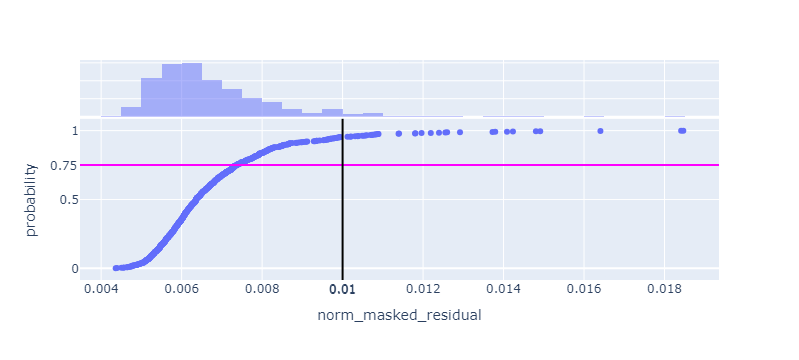

In [26]:
fig = px.ecdf(graphing_df, 
              #x = nmr,
              x = analysis_var,
              markers = True, 
              lines = False, 
              #facet_col = "Run ", 
              marginal = "histogram") #, facet_col_wrap = 1) # 

# yval = 0.79
# fig.add_hline(y = yval, 
#               row = 1,
#               col = 1,
#               line_color = "magenta",
#               annotation_text=f"{yval}",
#               annotation_position="left")

cutoff_val = 0.95 #1
fig.add_vline(x = cutoff_val, 
              row = 1,
              line_color = "black",
              annotation_text= f"{cutoff_val}", 
              annotation_position="bottom")

fig.show()

In [ ]:
run_name = run_name.strip()

print(f"Total number of galaxies attempted: {total_gal}")
print()
print(f"Number of Galfit models generated...")
print(f"{run_name}: {len(residual_df)}/{total_gal}, {100*len(residual_df)/total_gal:.2f}%")

cutoff = residual_df.query(f"{analysis_var} < {cutoff_val}")
print()
print(f"Residuals below {cutoff_val} cutoff")
print(f"{run_name}: {len(cutoff)}/{len(residual_df)}, {100*len(cutoff)/len(residual_df):.2f}%")

# print()
# print(f"Residuals below {cutoff_val} cutoff (excluding obscene failures)...")
# print(f"{run_name}: {len(cutoff)}/{len(graphing_df)}, {100*len(cutoff)/len(graphing_df):.2f}%")

In [28]:
def generate_images(input_df, png_dir:str, cutoff_val = 0.01, variable_name = "norm_masked_residual", custom_range = None):
    images_below_cutoff = []
    images_above_cutoff = []
    
    if not custom_range:
        custom_range = range(0, len(input_df), 500) 
    count = 0
    for index_num in custom_range:
        g_variable = input_df.iloc[index_num]
        gname = g_variable.name
        variable_value = g_variable[variable_name]

        # iloc returns a series, name returns the name of the row

        
        # print(f"chi^2/nu = {galaxy_info['chi^2_nu']:.2f}")
        # print(f"chi^2 = {galaxy_info['chi^2']:.2f}")
        #print(f"Norm GALFIT residual = {norm_galfit_residual:.4f}")

        # height = 500
        # width = 500
        # size = (height, width)
        out_str = f"{gname}_combined.png"
        
        if variable_value < cutoff_val:
            #images_below_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            images_below_cutoff.append(pj(png_dir, out_str))
            #images_below_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))
        else:
            count += 1
            if count == 1:
                print("="*80)
            #images_above_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            images_above_cutoff.append(pj(png_dir, out_str))
            #images_above_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))
            
        print(f"{gname}, sorted #: {index_num}")
        print(f"{variable_name} = {variable_value:.6f}")
        print()
    
    return images_below_cutoff, images_above_cutoff

In [ ]:
# fits_file = OutputFits(pj(galfit_tmp_path, fits_filename))
# fits_file.to_png(out_png_dir = out_png_dir)

In [ ]:
def generate_copy_file(imgs_below, imgs_above):
    with open("to_copy.sh", "w") as tc:
        tc.write("#!/bin/bash/\n\n")
        tc.write(f"cp -u {' '.join(imgs_below)} galfit_png\n")
        tc.write(f"cp -u {' '.join(imgs_above)} galfit_png\n")

In [29]:
# https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o
# Could also be useful https://eltos.github.io/gradient/#FFFFFF-A5A5A5-000000-A5A5A5-FFFFFF
png_dir = pj(run_path, out_dir, "galfit_png")
below, above = generate_images(norms_df, png_dir, cutoff_val = cutoff_val)#, custom_range = range(0, 30))
#generate_copy_file(below, above)

1237671262278582530, sorted #: 0
Norm masked residual = 0.004362



In [2]:
# For looking at individual galaxies
# gname = "1237665566076240061"
# gname_fits = OutputFits(pj(out_dir, gname, gname + "_galfit_out.fits"))
# print(gname_fits.feedme.arms)

In [ ]:
height = 500
width = 500

In [ ]:
below_images = [Image(filename = pj(png_dir, os.path.basename(i)), width=width, height=height) for i in below]
display(*below_images)

In [ ]:
above_images = [Image(filename = pj(png_dir, os.path.basename(i)), width=width, height=height) for i in above]
display(*above_images)

In [ ]:
# Grab top 1000 highest resolution galaxies from Darren's 27K and run this on those
# Change pitch angle plotting to only plot sparcfire's line between r_in and r_out and see how that compare to galfit
# Tile residuals for presentation???

In [ ]:
# Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)